In [57]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [58]:
def f(a, b, c, d, x):
    return a * np.cos(b * x) + c * np.sin(d * x)

a, b, c, d, n_input, n_hiden = 0.4, 0.2, 0.07, 0.2, 8, 3

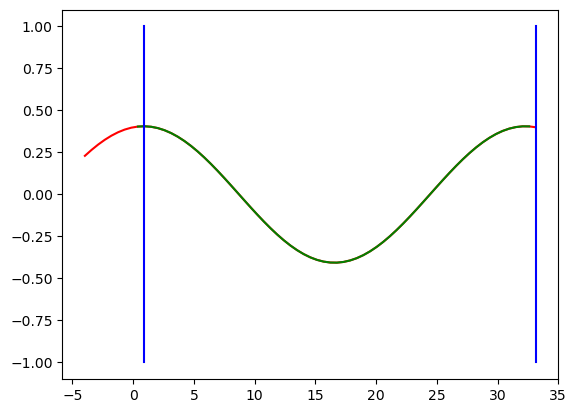

In [59]:
amount = 60
extra = n_input + 1
tspan = [0.866, 16.574 * 2]

step = (tspan[1] - tspan[0]) / amount
X = np.linspace(tspan[0] - step * extra, tspan[1], amount + extra)
y = np.array([f(a, b, c, d, _) for _ in X])
X_train = np.zeros((amount, n_input))
y_train = np.zeros((amount))
for i in range(n_input, amount + n_input): 
    X_train[i - n_input] = np.array([y[i + j - n_input] for j in range(n_input)])
    y_train[i - n_input] = y[i]
plt.plot(X, y, color='red')
plt.plot(X[n_input:-1], y_train, color='green')
plt.plot([tspan[0], tspan[0]], [-1, 1], color='blue')
plt.plot([tspan[1], tspan[1]], [-1, 1], color='blue')
plt.show()

In [60]:
class MLP: 
    
    def __init__(self, n_input, n_hidden, n_output, lr):
        self.n_input, self.n_hidden, self.n_output, self.lr = n_input, n_hidden, n_output, lr
        self.wildberries = {
            "weights_input_hidden": np.random.uniform(-1, 1, (n_input, n_hidden)),  
            "bias_input_hidden": np.zeros((n_hidden)), 
            "weights_hidden_output": np.random.uniform(-1, 1, (n_hidden, n_output)),
            "bias_hidden_output": np.zeros((n_output))  
        }
        self.aliexpress = {
            "weights_input_hidden": np.zeros((n_input, n_hidden)),  
            "bias_input_hidden": np.zeros((n_hidden)), 
            "weights_hidden_output": np.zeros((n_hidden, n_output)),
            "bias_hidden_output": np.zeros((n_output))  
        }
        self.lr_hidden = 0
        self.lr_output = 0.1
        
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_deriv(x):
        return np.where(x > 0, 1, 0)
        
    @staticmethod
    def sigmoid(x):
        return 2 / (1 + np.exp(-x)) - 1
    
    @staticmethod
    def sigmoid_deriv(x):
        return (1 - x * x) / 2
    
    @staticmethod
    def linear(x):
        return x
    
    @staticmethod
    def linear_deriv(x):
        return 1
    
    @staticmethod
    def mse(targets, predictions):
        return np.mean(np.square(targets - predictions))
        
    def forward(self, X): 
        self.input = X
        self.hidden = MLP.sigmoid(np.dot(self.input, self.wildberries["weights_input_hidden"]) + self.wildberries["bias_input_hidden"])
        self.output = MLP.sigmoid(np.dot(self.hidden, self.wildberries["weights_hidden_output"]) + self.wildberries["bias_hidden_output"])
        return self.output
    
    def backward(self, target, prediction):
        error_hidden_output = target - prediction
        deriv_hidden_output = error_hidden_output * self.sigmoid_deriv(self.output)
        
        self.aliexpress["weights_hidden_output"] += np.array([self.hidden]).T * deriv_hidden_output
        self.aliexpress["bias_hidden_output"] += np.sum(deriv_hidden_output)
        
        error_input_hidden = np.dot(deriv_hidden_output, self.wildberries["weights_hidden_output"].T)
        deriv_input_hidden = error_input_hidden * self.sigmoid_deriv(self.hidden)
        
        self.aliexpress["weights_input_hidden"] += np.dot(np.array([self.input]).T, np.array([deriv_input_hidden]))
        self.aliexpress["bias_input_hidden"] += np.sum(deriv_input_hidden)
        
        if self.lr == "adapt":
            error_square = np.square(error_hidden_output)
            error_square_sum_deriv = np.array([error_square]) * deriv_hidden_output
            zero_deriv = self.sigmoid_deriv(0)
            y_square = np.square(self.y[self.b:self.b+self.batch_size])
            one_plus_y_square = 1 + np.sum(y_square)
            deriv_square = np.square(deriv_hidden_output)
            zdopysesds = zero_deriv * one_plus_y_square * deriv_square
            self.lr_hidden = error_square_sum_deriv / zdopysesds / self.batch_size
            print(self.lr_hidden)

    def gradient_descent(self):
        if self.lr == "adapt":
            print(f"lr: {self.lr_hidden}")
            self.wildberries["weights_input_hidden"] += self.lr_hidden * self.aliexpress["weights_input_hidden"]
            self.wildberries["bias_input_hidden"] += np.sum(self.lr_hidden) * self.aliexpress["bias_input_hidden"]
            self.wildberries["weights_hidden_output"] += self.lr_output * self.aliexpress["weights_hidden_output"]
            self.wildberries["bias_hidden_output"] += np.sum(self.lr_output) * self.aliexpress["bias_hidden_output"]
            self.lr_hidden = 0
            self.lr_output = 1
        else:
            self.wildberries["weights_input_hidden"] += self.lr * self.aliexpress["weights_input_hidden"]
            self.wildberries["bias_input_hidden"] += self.lr * self.aliexpress["bias_input_hidden"]
            self.wildberries["weights_hidden_output"] += self.lr * self.aliexpress["weights_hidden_output"]
            self.wildberries["bias_hidden_output"] += self.lr * self.aliexpress["bias_hidden_output"]
        self.aliexpress = {
            "weights_input_hidden": np.zeros((self.n_input, self.n_hidden)),  
            "bias_input_hidden": np.zeros((self.n_hidden)), 
            "weights_hidden_output": np.zeros((self.n_hidden, self.n_output)),
            "bias_hidden_output": np.zeros((self.n_output))  
        }
        
    def train(self, X, y, batch_size, epochs):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        loss = []
        l = y.shape[0] // batch_size * batch_size
        for e in tqdm(range(epochs)):
            predictions = np.zeros(l)
            for b in range(0, l, batch_size):
                self.b = b
                for j in range(batch_size):
                    target = y[b + j]
                    predictions[b + j] = self.forward(X[b + j])
                    self.backward(target, predictions[b + j])
                self.gradient_descent()
            loss.append(MLP.mse(y, predictions))
        plt.plot(np.arange(0, epochs, 1), loss, color='blue')
        plt.show()
            
    def predict(self, X):
        return np.array([self.forward(x) for x in X])
                    

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:15<00:00, 201.64it/s]


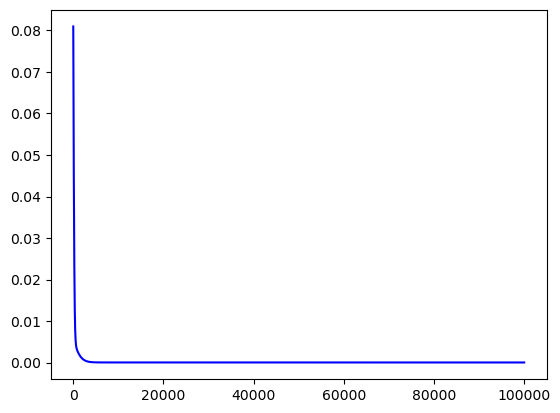

0.17084285694761642


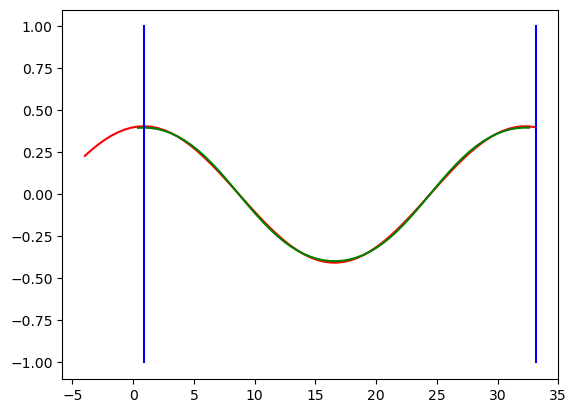

In [61]:
model = MLP(8, 3, 1, 0.001)
model.train(X_train, y_train, 1, 100000)
out = model.predict(X_train)
print(MLP.mse(y_train, out))

plt.plot(X, y, color='red')
plt.plot(X[n_input:-1], out, color='green')
plt.plot([tspan[0], tspan[0]], [-1, 1], color='blue')
plt.plot([tspan[1], tspan[1]], [-1, 1], color='blue')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [07:13<00:00, 230.50it/s]


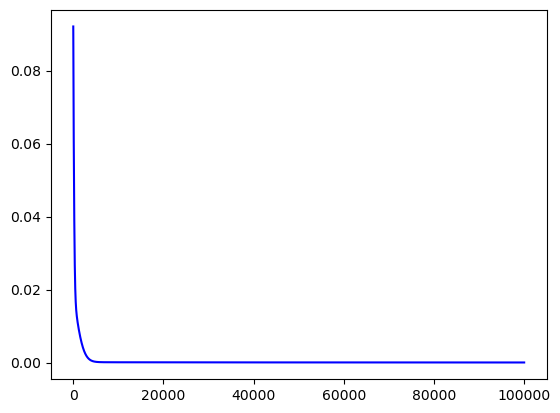

0.1708433278662667


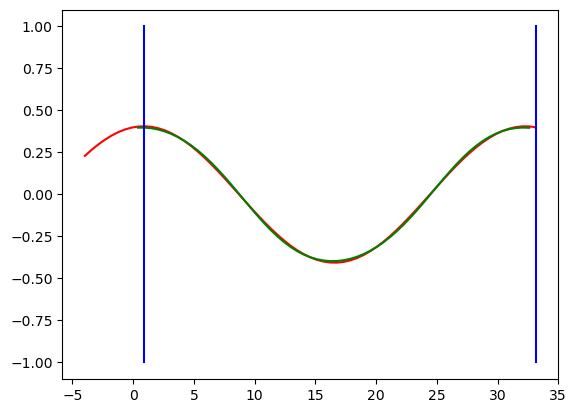

In [62]:
model = MLP(8, 3, 1, 0.001)
model.train(X_train, y_train, 10, 100000)
out = model.predict(X_train)
print(MLP.mse(y_train, out))

plt.plot(X, y, color='red')
plt.plot(X[n_input:-1], out, color='green')
plt.plot([tspan[0], tspan[0]], [-1, 1], color='blue')
plt.plot([tspan[1], tspan[1]], [-1, 1], color='blue')
plt.show()

In [63]:
# model = MLP(8, 3, 1, "adapt")
# model.train(X_train, y_train, 1, 100000)
# out = model.predict(X_train)
# print(MLP.mse(y_train, out))

# plt.plot(X, y, color='red')
# plt.plot(X[n_input:-1], out, color='green')
# plt.plot([tspan[0], tspan[0]], [-1, 1], color='blue')
# plt.plot([tspan[1], tspan[1]], [-1, 1], color='blue')
# plt.show()

In [64]:
# model = MLP(8, 3, 1, "adapt")
# model.train(X_train, y_train, 10, 10)
# out = model.predict(X_train)
# print(MLP.mse(y_train, out))

# plt.plot(X, y, color='red')
# plt.plot(X[n_input:-1], out, color='green')
# plt.plot([tspan[0], tspan[0]], [-1, 1], color='blue')
# plt.plot([tspan[1], tspan[1]], [-1, 1], color='blue')
# plt.show()

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.special import expit
import time
import csv
E_arr = []

class Perceptron :
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 0.05) :
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.start_rate = learning_rate
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.zeros((1, self.output_size))
        # print(self.weights_input_hidden)
        # print(self.weights_hidden_output)

    def sigmoid(self, x):
        return expit(x)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, inputs):
        self.hidden_input = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)
        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        return self.output

    def backward(self, inputs, target, output) :
        error = target - output
        delta_hidden = error.dot(self.weights_hidden_output.T) * self.sigmoid_derivative(self.hidden_output)
        self.weights_hidden_output += self.hidden_output.T.dot(error) * self.learning_rate
        self.bias_output += np.sum(error, axis = 0, keepdims = True) * self.learning_rate
        self.weights_input_hidden += inputs.T.dot(delta_hidden) * self.learning_rate
        self.bias_hidden += np.sum(delta_hidden, axis = 0, keepdims = True) * self.learning_rate
        
    def train(self, inputs, targets, epochs: int, isAdapt: bool = False) :
        global E_arr
        for epoch in range(epochs):
            e_arr = []
            for i in range(len(inputs)):
                input_data = np.array([inputs[i]])
                target_data = np.array([targets[i]])
                output = self.forward(input_data)
                e_arr.append(target_data - output)
                self.backward(input_data, target_data, output)
                E2 = np.sum(np.array(e_arr) ** 2) / 2
                E_arr.append(E2)
                self.learning_rate = self.start_rate * (1.0 / (1.0 + epoch / 100)) if isAdapt else self.learning_rate
                #print(f"Online: Epoch: {epoch} MSE: {E2} LR: {self.learning_rate}")

    def backwardBatch(self, inputs, targets, outputs) :
        error = (targets.T - outputs).T
        mse_batch = np.sum(error) / len(error)
        inputs_cut = 0
        for j  in range(len(error)): 
            inputs_cut += error[j] * inputs[j]
            mse_batch = np.array(mse_batch)
            inputs_cut = np.array(inputs_cut).reshape(1, -1)
            delta_hidden = mse_batch.dot(self.weights_hidden_output.T) * self.sigmoid_derivative(self.hidden_output)
            self.weights_hidden_output += self.hidden_output.T.dot(mse_batch) * self.learning_rate
            self.bias_output += np.sum(mse_batch, axis = 0, keepdims = True) * self.learning_rate
            self.weights_input_hidden += inputs_cut.T.dot(delta_hidden) * self.learning_rate
            self.bias_hidden += np.sum(delta_hidden, axis = 0, keepdims = True) * self.learning_rate
            
    def trainBatch(self, inputs, targets, epochs: int, batchsize: int, isAdapt: bool = False) :
        global E_arr
        if (len(inputs) % batchsize != 0) :
            print("Плохое значение пакета")
            return ValueError
        inputspack = [inputs[i - batchsize:i] for i in range(batchsize, len(inputs), batchsize)]
        targetspack = [targets[i - batchsize:i] for i in range(batchsize, len(targets), batchsize)]
        for epoch in range(epochs):
            e_arr = []
            for i in range(len(inputspack)):
                outputs = [self.forward(batchElem).item() for batchElem in inputspack[i]]
                for j in range(len(targetspack[i])): 
                    e_arr.append(targetspack[i][j] - outputs[j])
                    self.backwardBatch(inputspack[i], targetspack[i], outputs)
                    E2 = np.sum(np.array(e_arr) ** 2) / 2
                    E_arr.append(E2)
                    self.learning_rate = self.start_rate * (1.0 / (1.0 + epoch / 100)) if isAdapt else self.learning_rate
                    #print(f"Batch: Epoch: {epoch} MSE: {E2} LR: {self.learning_rate}")

    def predict(self, inputs) :
        output = self.forward(inputs)
        return output
    
def split_and_average(input_list, n):
    if n <= 0:
        raise ValueError("Параметр n должен быть больше нуля")
    
    result = []
    for i in range(0, len(input_list), n):
        group = input_list[i:i + n]
        average = sum(group) / len(group)
        result.append(average)
    
    return result
                   

Time taken: 24.510s
Точность модели : 0.77
Точность модели (MSE) : 0.0000000015
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82        99
         1.0       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154

Time taken: 20.610s
Точность модели: 0.75
Точность модели (MSE) : 0.0000187763
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        99
         1.0       0.69      0.56      0.62        55

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154

Time taken: 24.997s
Точность модели: 0.68
Точность модели (MSE) : 0.0000000270
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76        99

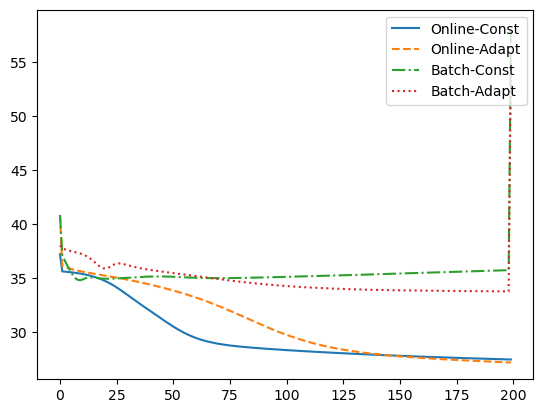

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75        99
         1.0       0.53      0.44      0.48        55

    accuracy                           0.66       154
   macro avg       0.62      0.61      0.61       154
weighted avg       0.65      0.66      0.65       154



In [3]:
epochs = 200
X, Y = [], []
with open(r"./diabetes.csv") as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader) :
        X.append([float(value) for value in row[:-1]])
        Y.append([float(row[-1])])
    X = np.array(X)
    Y = np.array(Y)
    X /= 1000

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

    perceptron = Perceptron(8, 1, 1)
    start = time.time()
    perceptron.train(X_train, y_train, epochs, False)
    end = time.time()
    temp = perceptron.predict(X_test)
    y_pred = (temp > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Time taken: {(end-start):.03f}s")
    print(f"Точность модели : {accuracy:.2f}")
    print(f"Точность модели (MSE) : {min(E_arr):.10f}")
    plt.plot(range(epochs), split_and_average(E_arr, X_train.shape[0]), '-')
    E_arr.clear()
    print(classification_report(y_test, y_pred, zero_division = 1))

    perceptron = Perceptron(8, 1, 1)
    start = time.time()
    perceptron.train(X_train, y_train, epochs, True)
    end = time.time()
    temp = perceptron.predict(X_test)
    y_pred = (temp > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Time taken: {(end-start):.03f}s")
    print(f"Точность модели: {accuracy:.2f}")
    print(f"Точность модели (MSE) : {min(E_arr):.10f}")
    plt.plot(range(epochs), split_and_average(E_arr, X_train.shape[0]), '--')
    E_arr.clear()
    print(classification_report(y_test, y_pred, zero_division = 1))

    perceptron = Perceptron(8, 1, 1)
    start = time.time()
    perceptron.trainBatch(X_train, y_train, epochs, 2, False)
    end = time.time()
    temp = perceptron.predict(X_test)
    y_pred = (temp > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Time taken: {(end-start):.03f}s")
    print(f"Точность модели: {accuracy:.2f}")
    print(f"Точность модели (MSE) : {min(E_arr):.10f}")
    plt.plot(range(epochs), split_and_average(E_arr, X_train.shape[0]), '-.')
    E_arr.clear()
    print(classification_report(y_test, y_pred, zero_division = 1))

    perceptron = Perceptron(8, 1, 1)
    start = time.time()
    perceptron.trainBatch(X_train, y_train, epochs, 2, True)
    end = time.time()
    temp = perceptron.predict(X_test)
    y_pred = (temp > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Time taken: {(end-start):.03f}s")
    print(f"Точность модели: {accuracy:.2f}")
    print(f"Точность модели (MSE) : {min(E_arr):.10f}")
    plt.plot(range(epochs), split_and_average(E_arr, X_train.shape[0]), ':')
    plt.legend(['Online-Const', 'Online-Adapt', 'Batch-Const', 'Batch-Adapt'], loc = "upper right")
    plt.show()
    print(classification_report(y_test, y_pred, zero_division = 1))


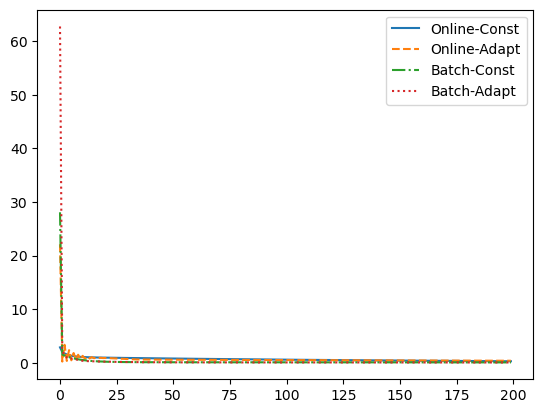

In [5]:
import time
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import expit
E_arr_arr=[]
E_arr = []
f = lambda x: 0.4 * np.cos(0.2 * x) + 0.07 * np.sin(0.2 * x)

def normalize_data(data, min_val, max_val):
    min_data = np.min(data)
    max_data = np.max(data)
    normalized_data = (data - min_data) / (max_data - min_data) * (max_val - min_val) + min_val
    return normalized_data

class Network:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.start_learn_rate =  learning_rate

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.random.randn(1, self.hidden_size)
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.random.randn(1, self.output_size)

    def sigmoid(self, x):
        return expit(x)
    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, inputs):
        self.hidden_input = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)
        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        return self.output
    def predict(self, inputs):
        output = self.forward(inputs)
        result = [el[0] for el in output]
        return normalize_data(result, -0.13446, 0.13446)
    
    def backward(self, inputs, target, output):
        error = target - output
        delta_hidden = error.dot(self.weights_hidden_output.T) * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += self.hidden_output.T.dot(error) * self.learning_rate
        self.bias_output += np.sum(error, axis=0, keepdims=True) * self.learning_rate
        self.weights_input_hidden += inputs.T.dot(delta_hidden) * self.learning_rate
        self.bias_hidden += np.sum(delta_hidden, axis=0, keepdims=True) * self.learning_rate

    def backwardBatch(self, inputs, targets, outputs):
        error = targets - outputs
        mse_batch = np.sum(error)/len(error)
        inputs_cut = 0
        for j  in range(len(error)): inputs_cut += error[j]*inputs[j]
        mse_batch = np.array(mse_batch)
        inputs_cut = np.array(inputs_cut).reshape(1,-1)
        delta_hidden = mse_batch.dot(self.weights_hidden_output.T) * self.sigmoid_derivative(self.hidden_output)
        self.weights_hidden_output += self.hidden_output.T.dot(mse_batch) * self.learning_rate
        self.bias_output += np.sum(mse_batch, axis=0, keepdims=True) * self.learning_rate
        self.weights_input_hidden += inputs_cut.T.dot(delta_hidden) * self.learning_rate
        self.bias_hidden += np.sum(delta_hidden, axis=0, keepdims=True) * self.learning_rate

    def train(self, inputs, targets, epochs: int,isAdapt:bool = False):
        global E_arr
        for epoch in range(epochs):
            e_arr = []
            for i in range(len(inputs)):
                input_data = np.array([inputs[i]])
                target_data = np.array([targets[i]])
                output = self.forward(input_data)
                e_arr.append(targets[i] - output)
                self.backward(input_data, target_data, output)
            E2 = np.sum(np.array(e_arr)**2)/2
            E_arr.append(E2)
            self.learning_rate = min(0.2,max(self.learning_rate * E2,0.0046)) if isAdapt else self.learning_rate
            #print(f"Online: Epoch: {epoch} MSE: {E2}")
    def trainBatch(self,inputs,targets,epochs: int,batchsize: int, isAdapt: bool = False):
        global E_arr
        if(len(inputs) % batchsize != 0): return ValueError
        inputspack= [inputs[i-batchsize:i] for i in range(batchsize,len(inputs),batchsize)]
        targetspack= [targets[i-batchsize:i] for i in range(batchsize,len(targets),batchsize)]
        for epoch in range(epochs):
            e_arr = []
            for i in range(len(inputspack)):
                outputs = [self.forward(batchElem).item() for batchElem in inputspack[i]]                
                e_arr.append(np.mean(targetspack[i]-outputs))
                self.backwardBatch(inputspack[i], targetspack[i], outputs)
            E2 = np.sum(np.array(e_arr)**2)/2
            E_arr.append(E2)
            self.learning_rate = min(0.2,max(self.learning_rate * E2,0.0046)) if isAdapt else self.learning_rate
            #print(f"Batch: Epoch: {epoch} MSE: {E2}")

def get_train_data(all_points, input_size):
    result_X = [all_points[i:i+input_size] for i in range(len(all_points) - input_size)]
    result_Y = [all_points[i] for i in range(input_size, len(all_points), 1)]
    return np.array(result_X), np.array(result_Y)

input_size = 8
hidden_size = 3
output_size = 1
epochs = 200

all_train_points = f(np.arange(100, 200, 0.2))
all_test_points = f(np.arange(180, 280, 0.2))
X_train, Y_train = get_train_data(all_train_points, input_size)
X_test, Y_test = get_train_data(all_test_points, input_size)

def cutVer(E_arr,epochs,all_train_points,predicted,start,end):
    print(f"Time taken: {(end-start)*10**3:.03f}ms")
    print(min(E_arr))
    plt.plot(range(0,epochs),E_arr)
    plt.show()
    plt.plot(np.arange(100, 200, 0.2), all_train_points)
    plt.plot(np.arange(181.6, 280, 0.2), predicted,":")
    plt.show()


#Online-Const
NN = Network(input_size, hidden_size, output_size)
start = time.time()
NN.train(X_train, Y_train, epochs,False)
E_arr_arr.append(E_arr)
end = time.time()
predicted = NN.predict(X_test)
#cutVer(E_arr,epochs,all_train_points,predicted,start,end)
#Online-Adapt
E_arr=[]
NN2 = Network(input_size, hidden_size, output_size)
start = time.time()
NN2.train(X_train, Y_train, epochs,True)
E_arr_arr.append(E_arr)
end = time.time()
predicted = NN2.predict(X_test)
#cutVer(E_arr,epochs,all_train_points,predicted,start,end)
#Batch-Const
E_arr=[]
NN3 = Network(input_size, hidden_size, output_size)
start = time.time()
NN3.trainBatch(X_train, Y_train, epochs,4,False)
E_arr_arr.append(E_arr)
end = time.time()
predicted = NN3.predict(X_test)
#cutVer(E_arr,epochs,all_train_points,predicted,start,end)
#Batch-Adapt
E_arr=[]
NN4 = Network(input_size, hidden_size, output_size)
start = time.time()
NN4.trainBatch(X_train, Y_train, epochs,4,True)
E_arr_arr.append(E_arr)
end = time.time()
predicted = NN4.predict(X_test)
#cutVer(E_arr,epochs,all_train_points,predicted,start,end)
plt.plot(range(epochs),E_arr_arr[0],"-")
plt.plot(range(epochs),E_arr_arr[1],"--")
plt.plot(range(epochs),E_arr_arr[2],"-.")
plt.plot(range(epochs),E_arr_arr[3],":")
plt.legend(['Online-Const','Online-Adapt','Batch-Const','Batch-Adapt'],loc="upper right")
plt.show()

